In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
%matplotlib inline

In [2]:
# Scaling or clipping
scale = lambda x : (255 * (x - np.min(x))) / (np.max(x) - np.min(x))
inrange = lambda x: np.where(x > 255, 255, np.where(x < 0, 0, x))

In [3]:
input_texture = cv2.imread('../images/input.png')
input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

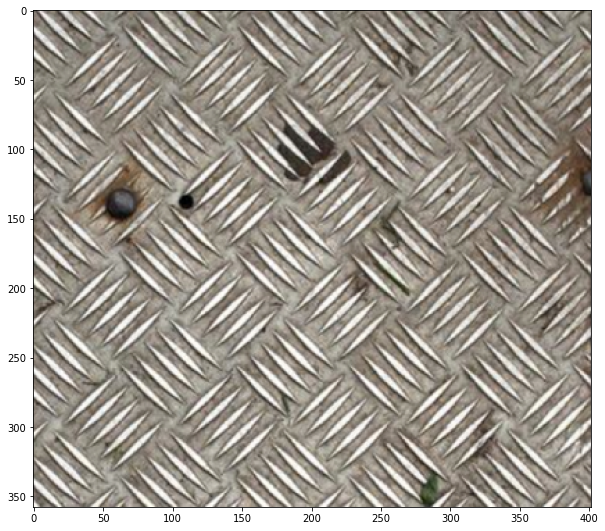

In [4]:
plt.figure(figsize=(10, 10))

plt.imshow(input_texture)

plt.show()

In [5]:
def luminance(img):
    
    img = img.astype('float64')
    
    with np.errstate(divide='ignore', invalid='ignore'):
        intensity_layer = np.nan_to_num(np.true_divide(((img[:, :, 0]**2) + (img[:, :, 1]**2) + (img[:, :, 2]**2)) , (img[:,:,0]+img[:, :, 1]+img[:, :, 2])))
    return intensity_layer

In [6]:
details = luminance(input_texture)

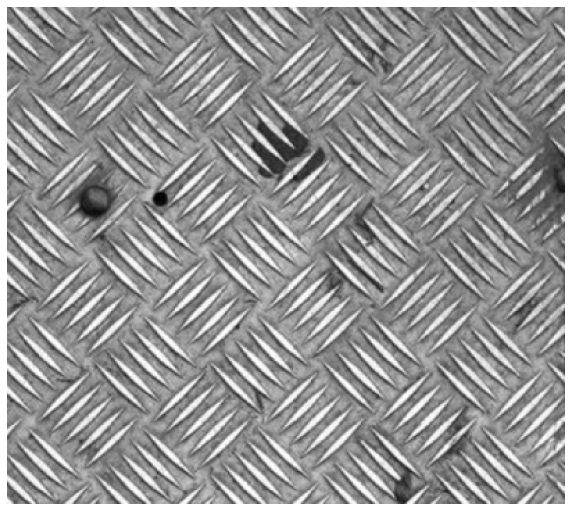

In [7]:
plt.figure(figsize=(10, 10))

plt.imshow(details, cmap='gray')
plt.axis('off')

plt.show()

In [8]:
def apply_filter(im, filt, zero_padding=False):
    
    wdth = filt.shape[0]//2
    
    filt_img = np.zeros(im.shape)
    
    if zero_padding:
        im = np.vstack( (np.zeros( (wdth, im.shape[1]) ), im, np.zeros( (wdth, im.shape[1]) ) ) )
        im = np.hstack( (np.zeros( (im.shape[0], wdth) ), im, np.zeros( (im.shape[0], wdth) ) ) )
    else:
        im = np.vstack(([im[0]]*wdth, im, [im[-1]]*wdth))
        im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*wdth)))

    for i in range(wdth, im.shape[0]-wdth):
        for j in range(wdth, im.shape[1]-wdth):
            filt_img[i-wdth][j-wdth] = np.sum(im[i-wdth:i+wdth+1, j-wdth:j+wdth+1] * filt)
    
    return np.rint(filt_img)

prewitt =  [np.array([
                [-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]
        ]) , np.array([
                [ 1,  1,  1],
                [ 0,  0,  0],
                [-1, -1, -1]
        ])]


In [9]:
dx = apply_filter(details, prewitt[0])
dy = apply_filter(details, prewitt[1])
gradient = np.nan_to_num(np.arctan(dy/dx))

/home/mohee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
N = 20

source_patch_one = input_texture[205:205+N, 165:165+N, :]
source_patch_l = details[0:N, 0:N]
source_patch_g = gradient[205:205+N, 165:165+N]

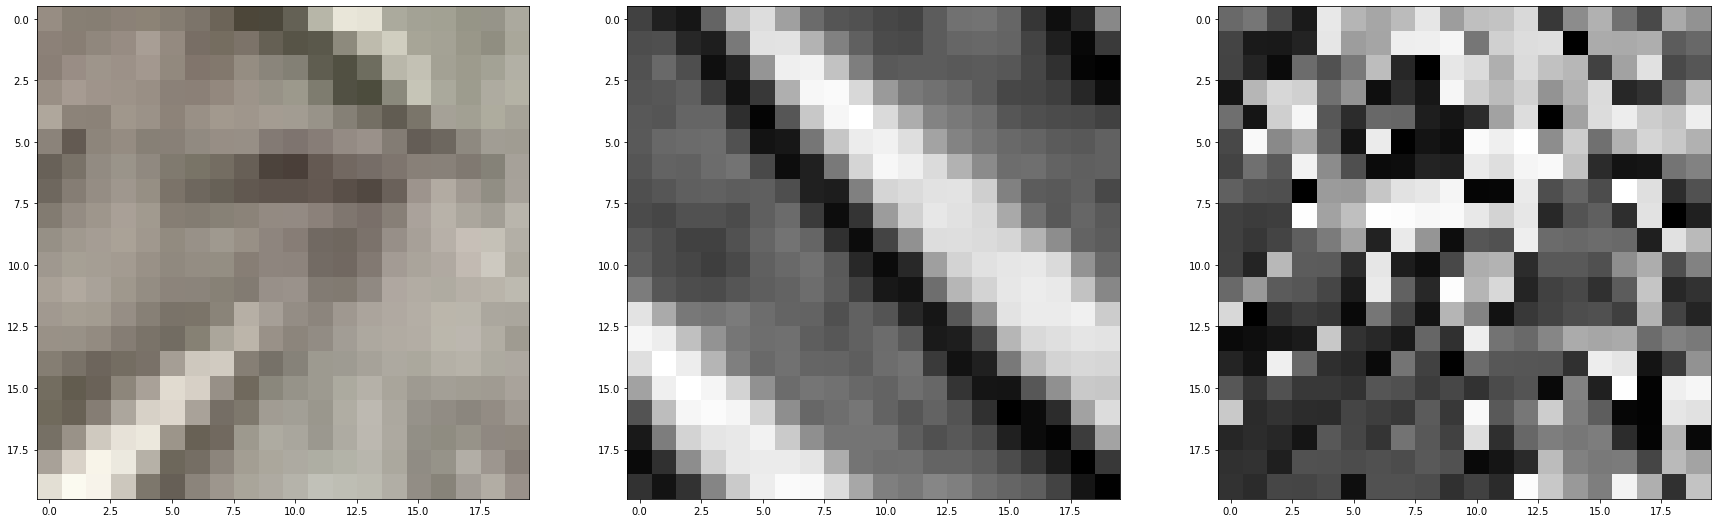

In [24]:
plt.figure(figsize = (30, 30))

plt.subplot(131)
plt.imshow(source_patch_one, cmap='gray')

plt.subplot(132)
plt.imshow(source_patch_l, cmap='gray')

plt.subplot(133)
plt.imshow(source_patch_g, cmap='gray')

plt.show()

In [13]:
def distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2

    tI = np.vstack(([tI[0]]*wdth_y, tI, [tI[-1]]*(Y-wdth_y)))
    tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x))))

    tG = np.vstack(([tG[0]]*wdth_y, tG, [tG[-1]]*(Y-wdth_y)))
    tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x))))
   
    g_img = np.zeros((M, N))
    l_img = np.zeros((M, N))
   
    for i in range(wdth_y, wdth_y+M):
        for j in range(wdth_x, wdth_x+N):

            g_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sG - tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            l_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sI - tI[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            
    return (g_img / np.max(g_img)) + (l_img / np.max(l_img))

In [14]:
def median_filter(im, k):
        
    filt_img = np.zeros(im.shape)

    wdth = k//2

    im = np.vstack(([im[0]]*wdth, im, [im[-1]]*(k-wdth)))
    im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*(k-wdth))))

    for j in range(wdth, im.shape[1]-wdth):
        for i in range(wdth, im.shape[0]-wdth):
            x = np.median(im[i-wdth:i+k-wdth+1, j-wdth:j+k-wdth+1])
            filt_img[i-wdth][j-wdth] = x
    return filt_img

In [22]:
%%time
for_2 = distance(source_patch_l, source_patch_g, details, gradient)

CPU times: user 3.45 s, sys: 7.16 ms, total: 3.46 s
Wall time: 3.46 s


In [16]:
def age(source_patch, target, K):
    
    sI, sG = source_patch
    tI, tG = target
    dist_mat = distance(sI, sG, tI, tG)

    discrete = np.rint(scale(dist_mat)).astype('uint8')
    discrete = median_filter(discrete, sI.shape[1])

    K_distances = np.sort(np.unique(discrete).flatten())[:10]
    co_ords = []
    for i in K_distances:
        x, y = np.where(discrete == i)
        co_ords.append((x[-1], y[-1]))

    K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]

    return np.average(K_neighbours)



In [52]:
%%time
age1 = age((source_patch_l, source_patch_g), (details, gradient), 10)

CPU times: user 5.69 s, sys: 19.9 ms, total: 5.71 s
Wall time: 5.73 s


In [17]:
def generate_age_map(I, G, N, K):

    age_map = np.zeros(I.shape, dtype=('float64'))

    for i in range(0, I.shape[0], N):
        for j in range(0, I.shape[1], N):
            x1, x2 = i, min(I.shape[0], i+N)
            y1, y2 = j, min(I.shape[1], j+N)
            age_map[x1:x2, y1:y2] = age( (I[x1:x2, y1:y2], G[x1:x2, y1:y2]) , (I, G), K)

    return age_map


In [18]:
b = np.rint(scale(for_2)).astype('uint8')
b = median_filter(b, 10)

In [19]:
# %%time
a = np.rint(scale(for_1)).astype('uint8')
a = median_filter(a, 10)

NameError: name 'for_1' is not defined

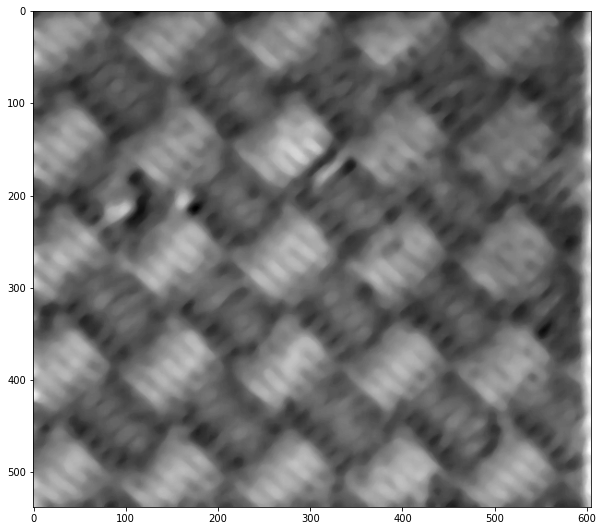

In [79]:
plt.figure(figsize=(10, 10))

plt.imshow(b, cmap='gray')

plt.show()

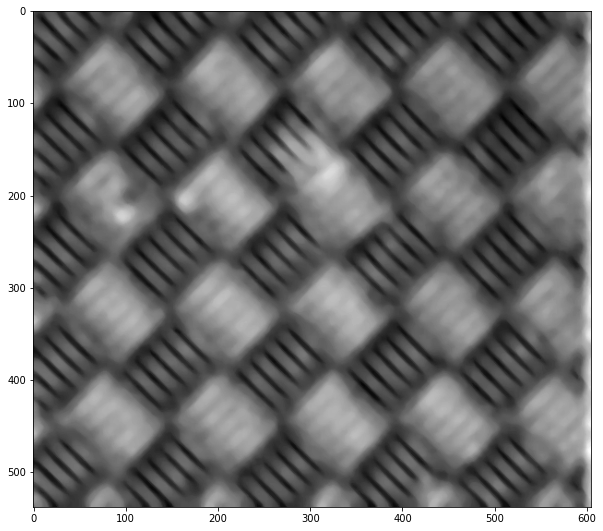

In [24]:
plt.figure(figsize=(10, 10))

plt.imshow(a, cmap='gray')

plt.show()

In [25]:
K_distances = np.sort(np.unique(a).flatten())[:10]

In [80]:
K2_distances = np.sort(np.unique(b).flatten())[:10]

In [81]:
K2_distances

array([146., 147., 148., 149., 150., 151., 152., 153., 154., 155.])

In [26]:
K_distances

array([127., 128., 129., 130., 131., 132., 133., 134., 135., 136.])

In [82]:
co_ords2 = []
for i in K2_distances:
    x, y = np.where(b==i)
    co_ords2.append((x[-1], y[-1]))

In [83]:
print(co_ords2)

[(215, 176), (215, 177), (216, 177), (217, 175), (215, 178), (347, 554), (348, 553), (349, 552), (350, 552), (350, 553)]


In [27]:
co_ords = []
for i in K_distances:
    x, y = np.where(a==i)
    co_ords.append((x[-1], y[-1]))

In [28]:
print(co_ords)

[(113, 530), (15, 533), (127, 544), (537, 148), (147, 514), (537, 149), (537, 394), (537, 516), (537, 510), (537, 390)]


In [33]:
K_neighbours = [for_1[x, y] for (x, y) in co_ords]
K_neighbours2 = [a[x, y] for (x, y) in co_ords]

In [85]:
K2_neighbours = [for_2[x, y] for (x, y) in co_ords2]
K2_neighbours2 = [b[x, y] for (x, y) in co_ords2]

In [88]:
print(np.average(K_neighbours), np.average(K_neighbours2))

199.0595833504054 131.5


In [87]:
print(np.average(K2_neighbours), np.average(K2_neighbours2))

227.74089410269616 150.5


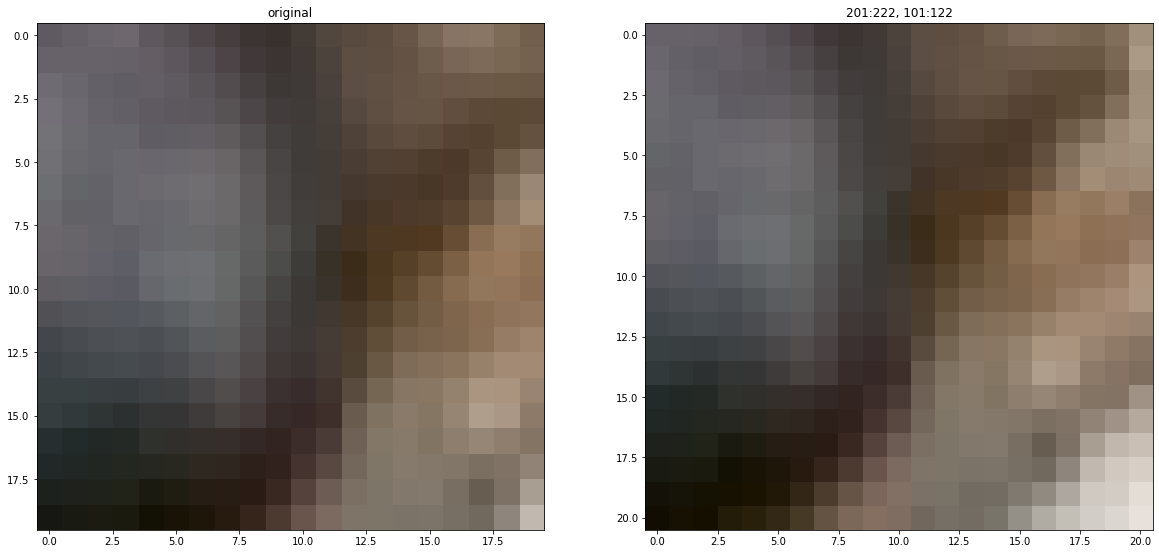

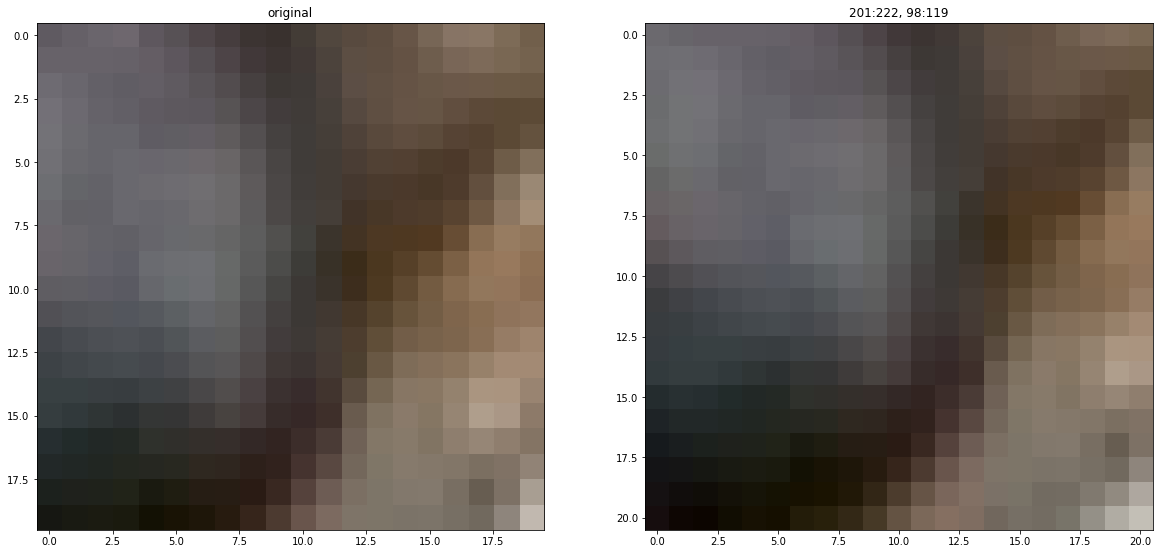

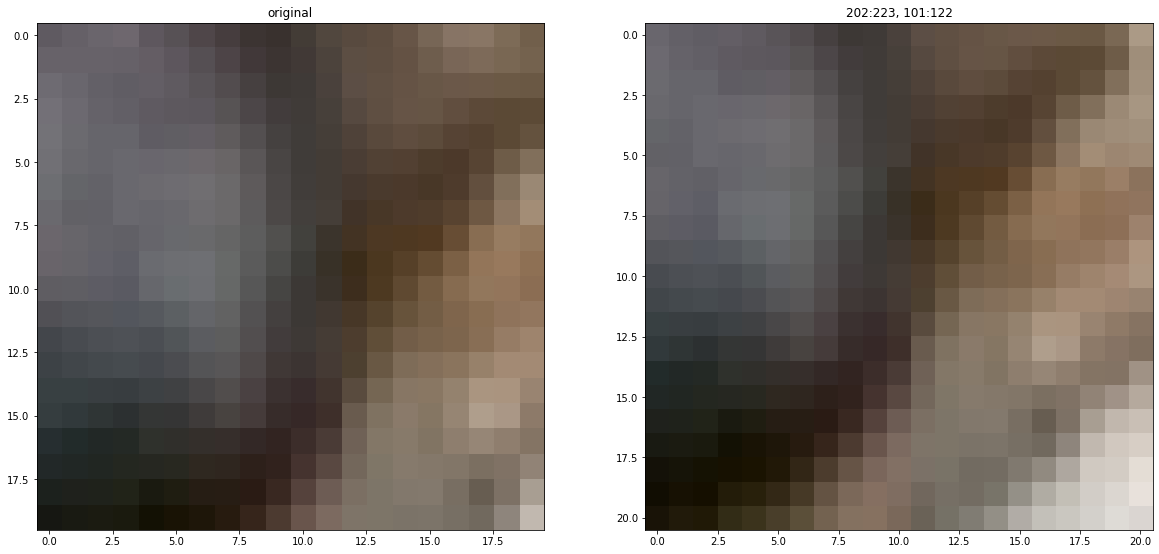

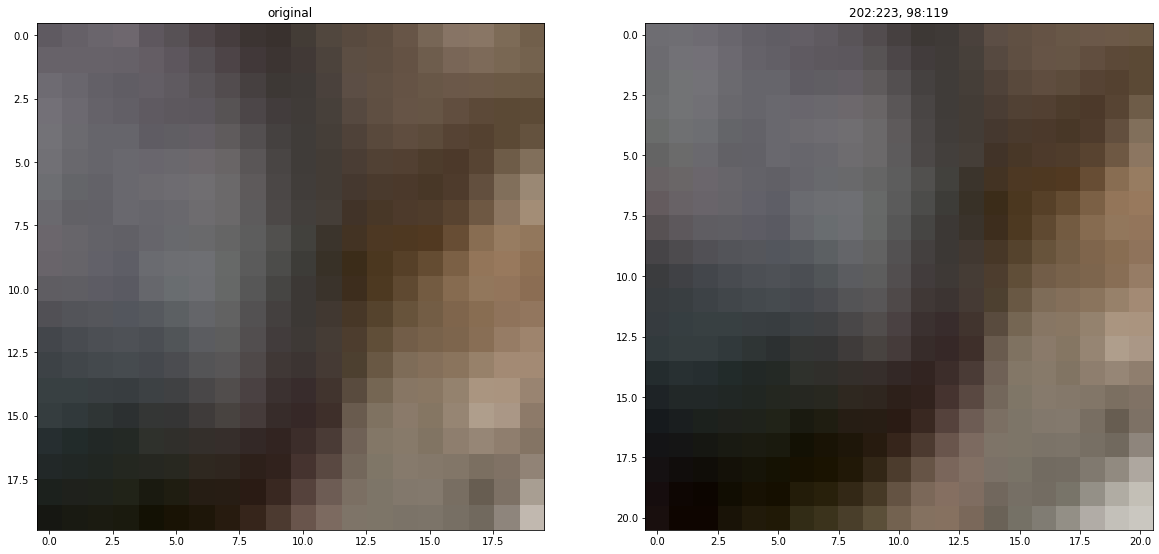

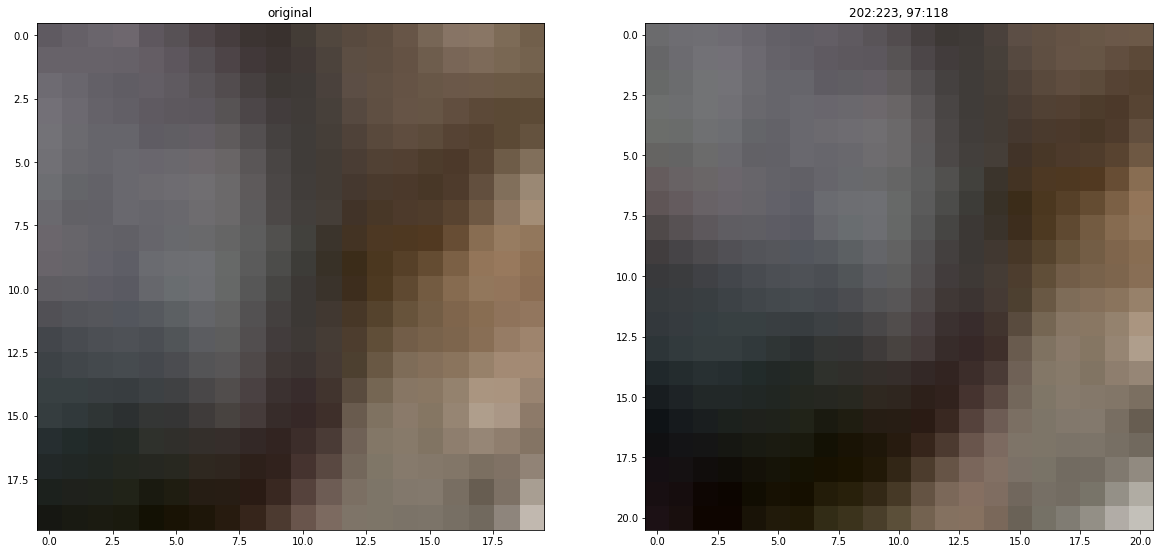

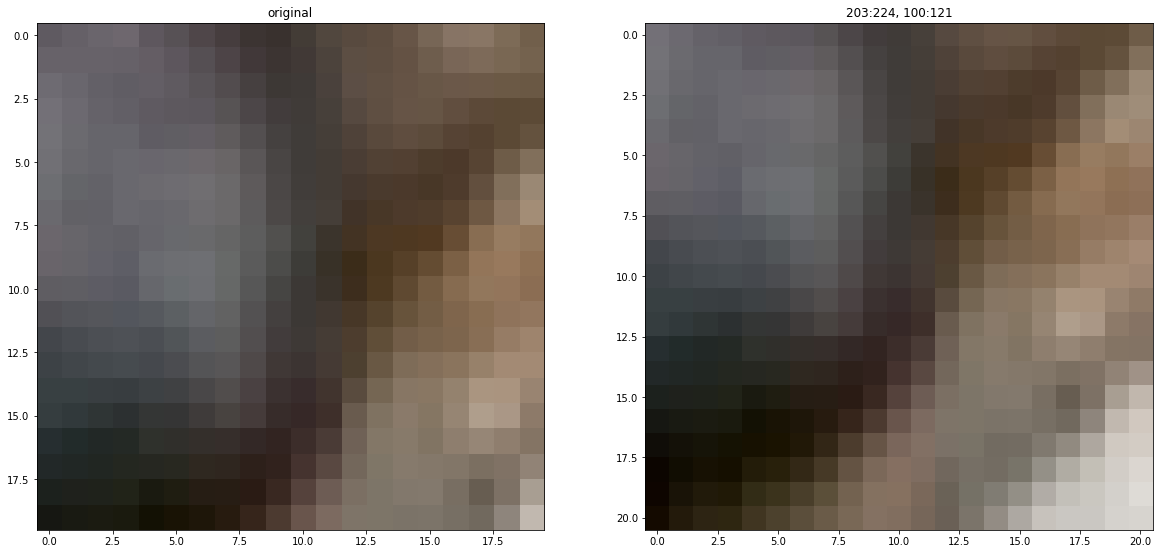

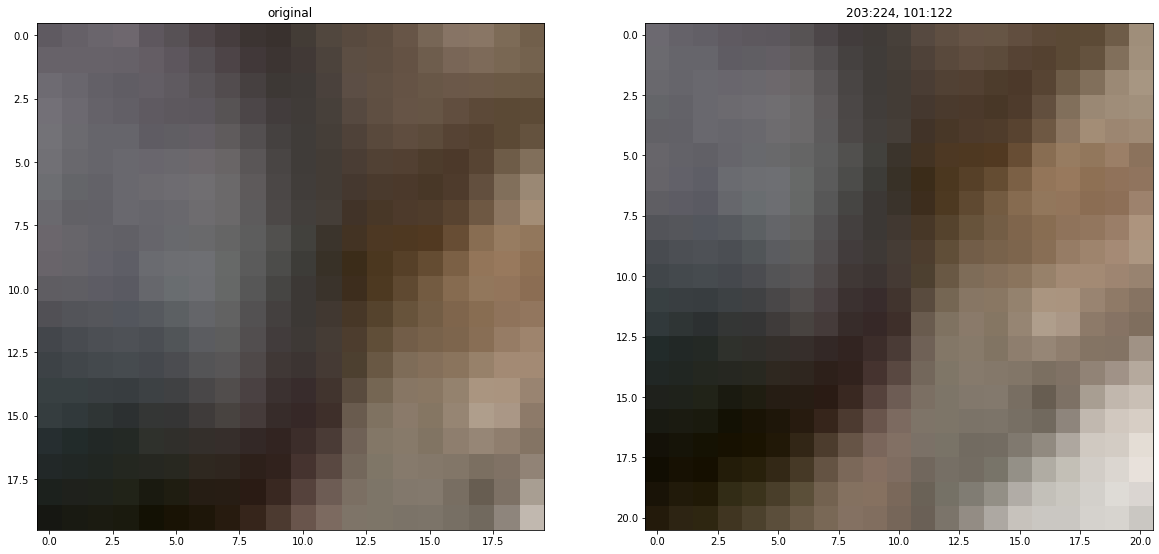

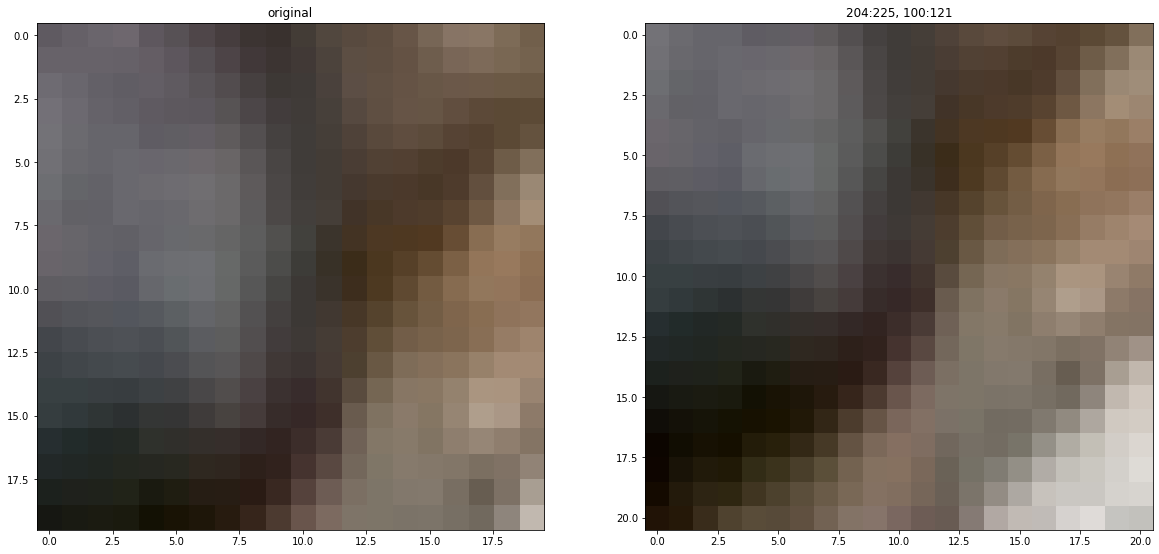

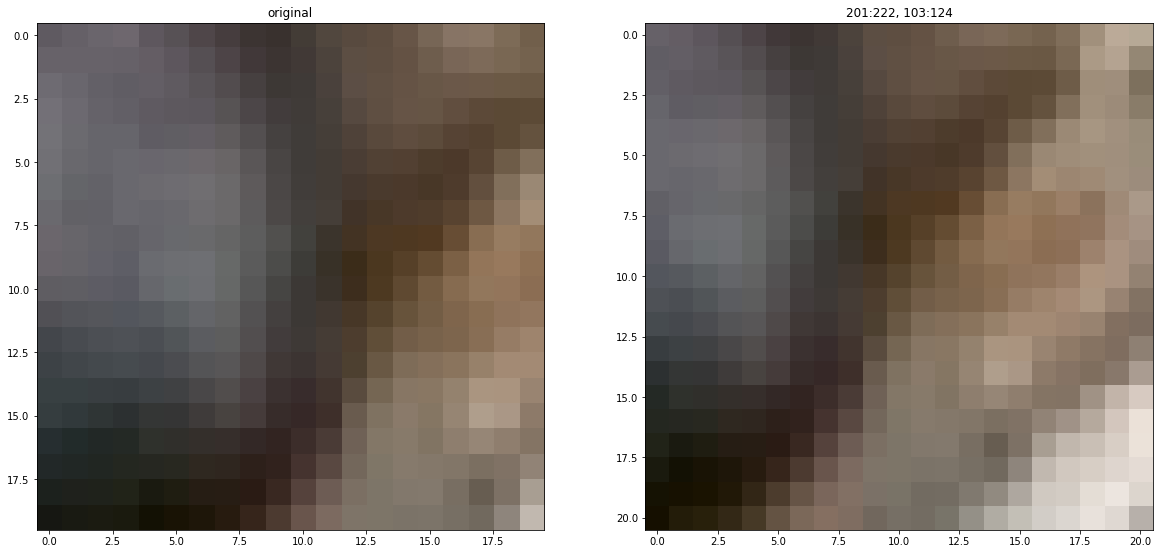

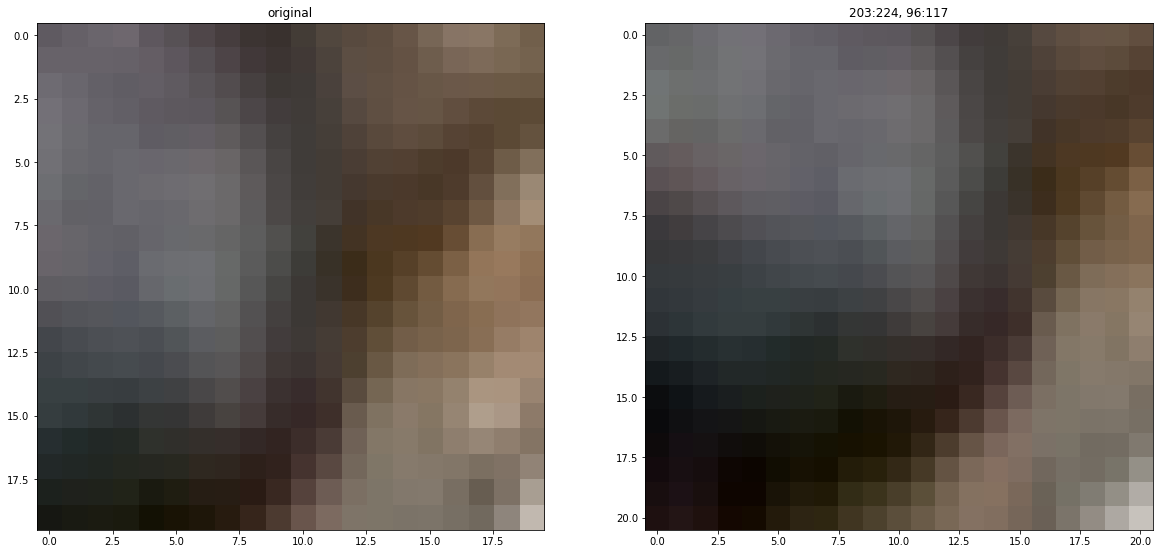

In [55]:
for (i, j) in co_ords2:
    min_x = max(i-10, 0)
    min_y = max(j-10, 0)
    max_x = min(i+11, input_texture.shape[0])
    max_y = min(j+11, input_texture.shape[1])
    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.imshow(source_patch_one)
    plt.title("original")

    plt.subplot(122)
    plt.imshow(input_texture[min_x:max_x, min_y:max_y])
    plt.title(f"{min_x}:{max_x}, {min_y}:{max_y}")
    plt.show()

In [113]:
%%time
age_map = generate_age_map(details, gradient, 20, 10)

CPU times: user 48.2 s, sys: 32.3 ms, total: 48.2 s
Wall time: 47.8 s


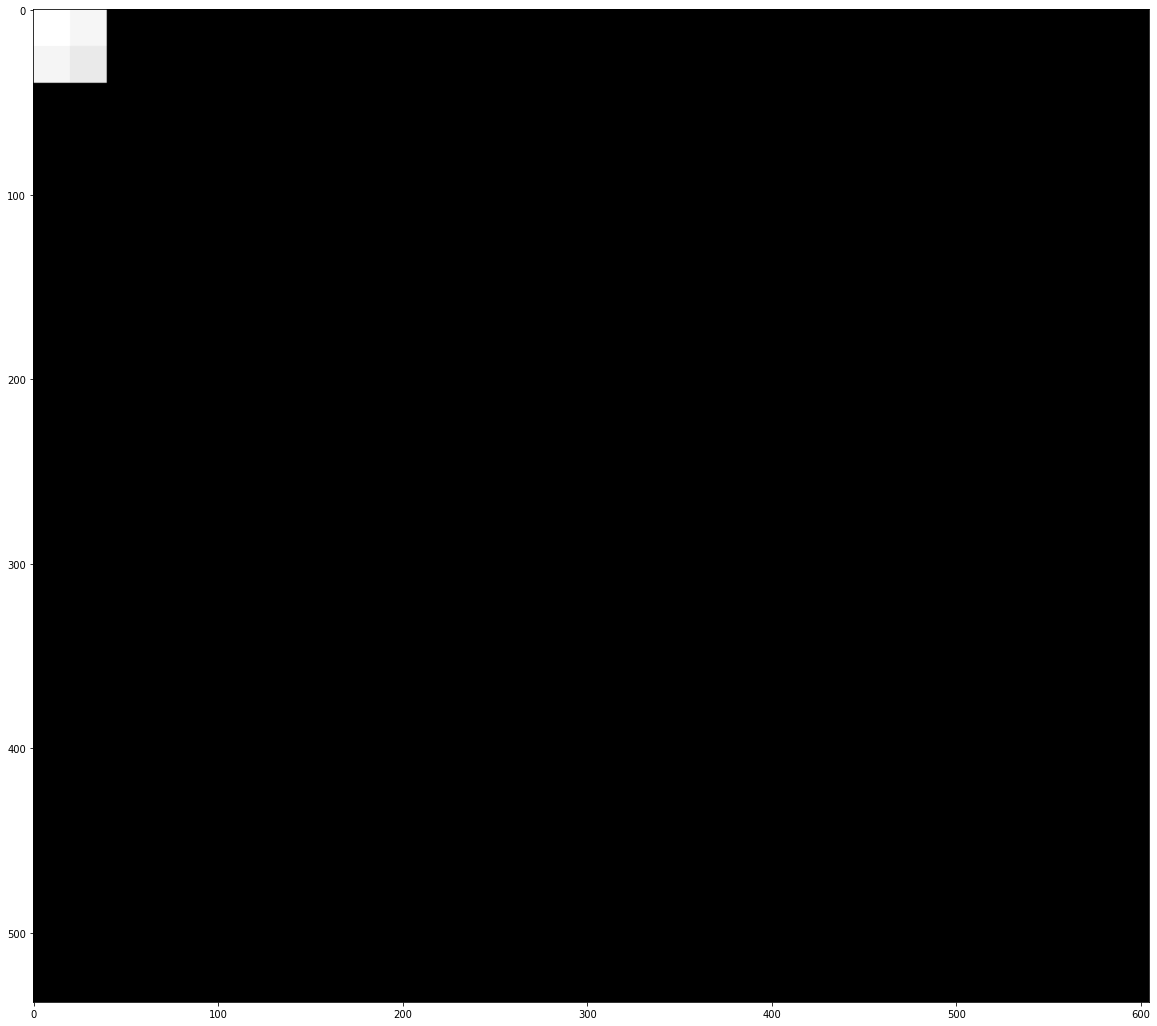

In [125]:
plt.figure(figsize=(20, 20))

plt.imshow(age_map, cmap='spring_r')

plt.show()

In [119]:
coo = []
for i in range(0, details.shape[0], 20):
    for j in range(0, details.shape[1], 20):
        coo.append((i, j))

In [120]:
len(coo)

837

In [122]:
(12.2 * 837) / (60*60)

2.8365

In [121]:
details.shape

(538, 605)

In [40]:
a,b,c=input_texture.shape

N = a//3

source_patch_one = input_texture[:N,:N, :]
source_patch_l = details[:N, :N]
source_patch_g = gradient[:N, :N]

In [41]:
%%time
dist_map = distance(source_patch_l, source_patch_g, details, gradient)

CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.4 s


(-0.5, 401.5, 357.5, -0.5)

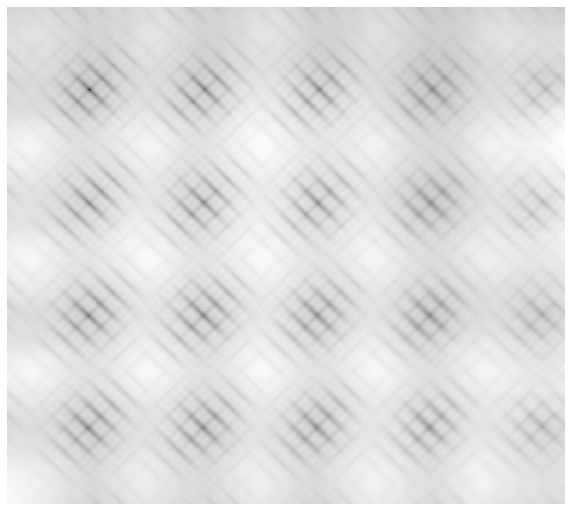

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(dist_map,cmap='gray')
plt.axis('off')

In [78]:
N

119

In [76]:
def local_minimas(dist_map,N):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N):
        for j in range(0,b,N):
            X=min(i+N,a)
            Y=min(j+N,b)
            patch=dist_map[i:X,j:Y]
            thresh=np.unique(patch)[np.rint(0.005*(X-i)*(Y-j)).astype('uint8')]
#             plt.figure(figsize=(10,10))
#             plt.imshow(patch<thresh,cmap='gray')
#             plt.axis('off')
            minima[i:X,j:Y]=patch<thresh     
                      
    return minima                  
                      
                      
                      
                     


(-0.5, 44.5, 0.5, -0.5)

<Figure size 720x720 with 0 Axes>

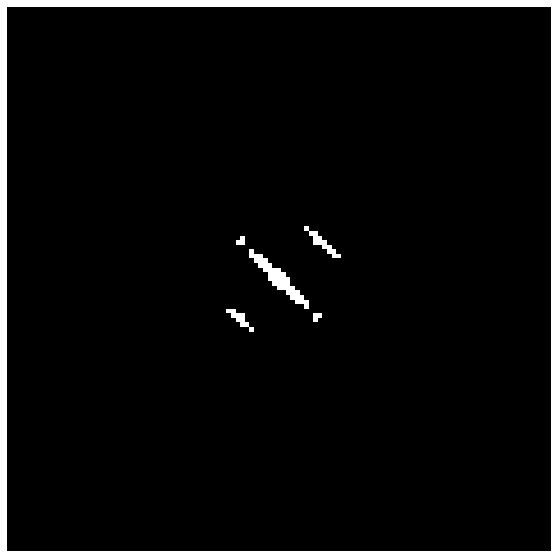

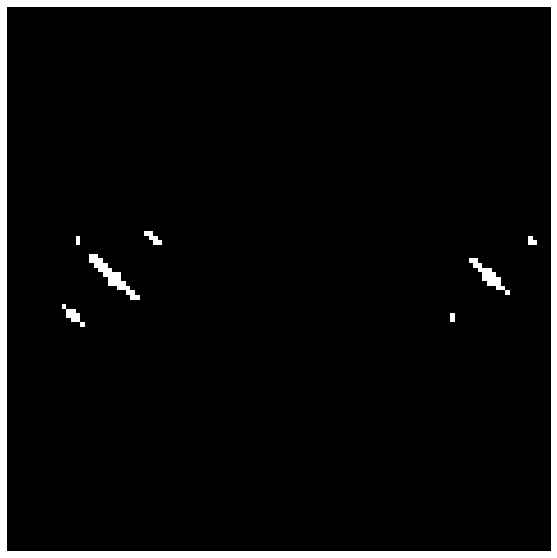

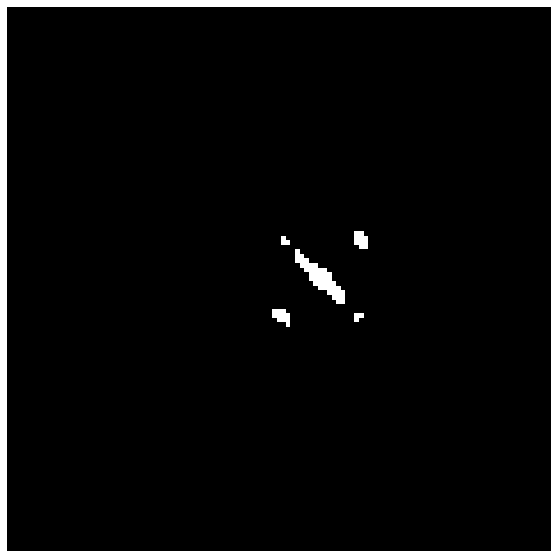

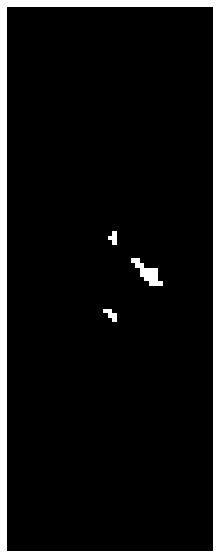

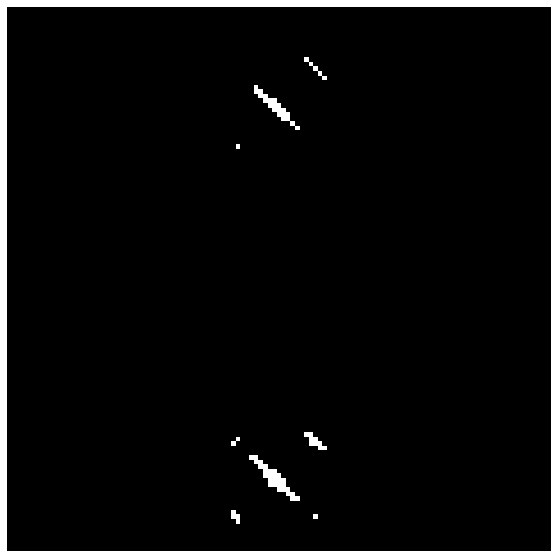

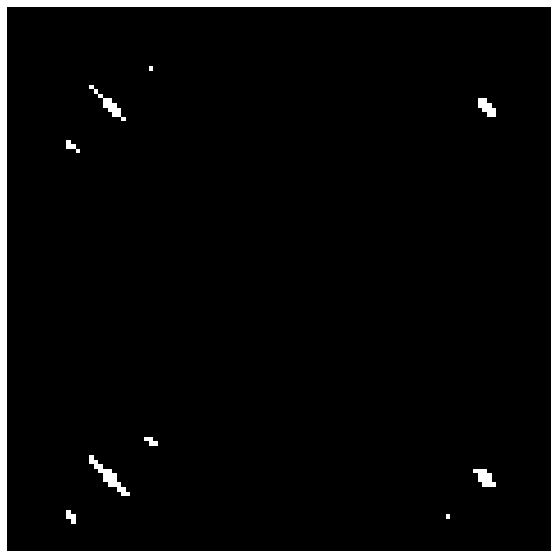

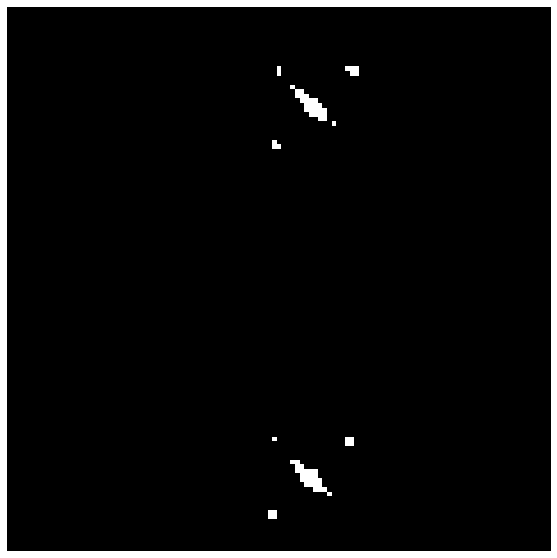

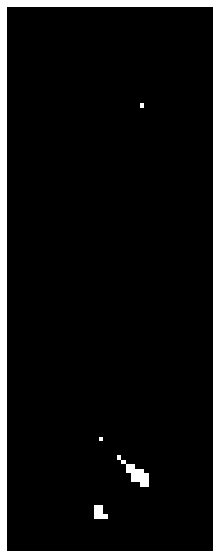

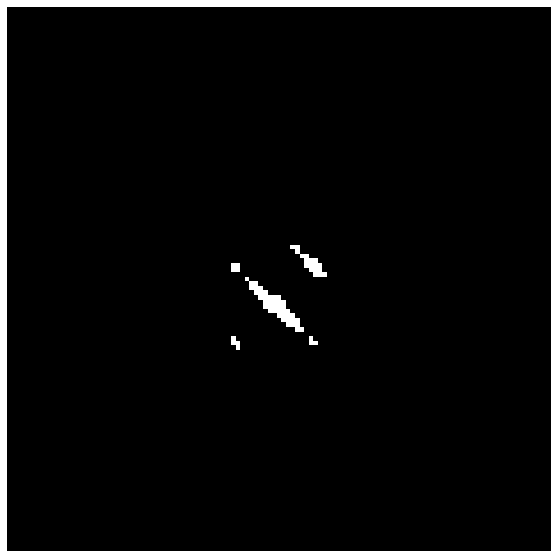

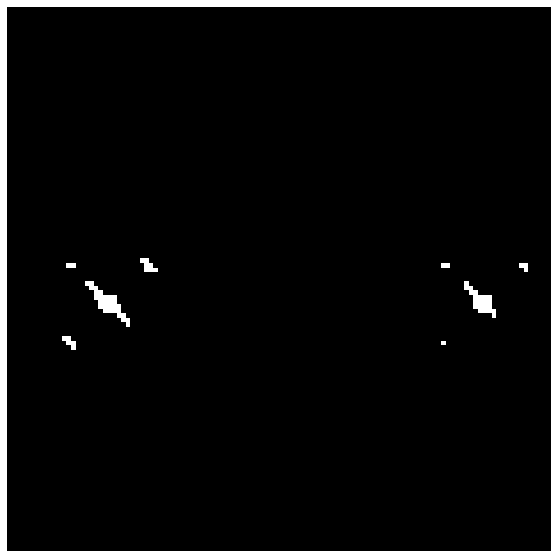

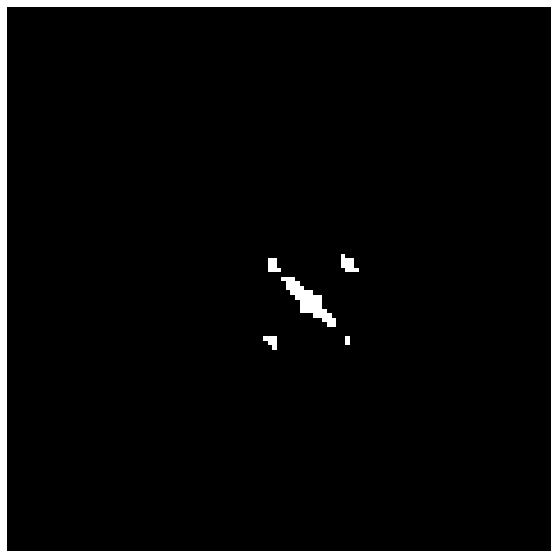

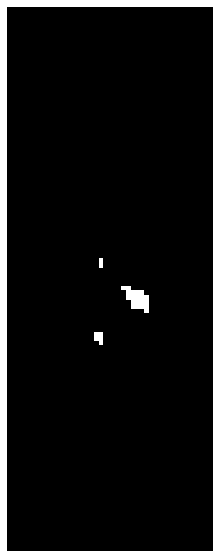

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(local_minimas(dist_map,N),cmap='gray')
plt.axis('off')

(-0.5, 401.5, 357.5, -0.5)

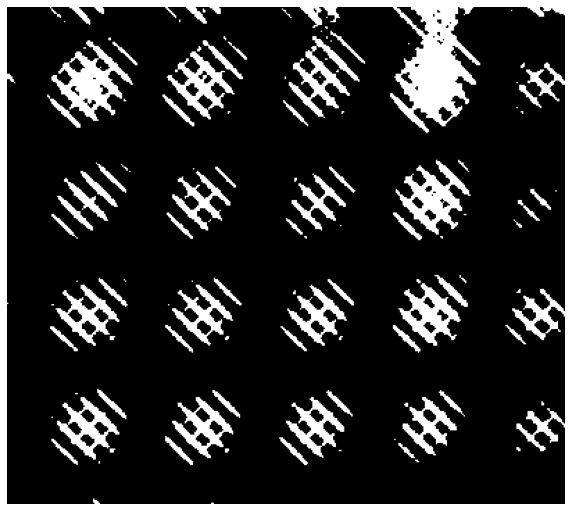

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(dist_map<1.5,cmap='gray')
plt.axis('off')